<a href="https://colab.research.google.com/github/StoyanBoyukliyski/Tic_Tac_Toe/blob/main/chris_linear_optimization_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization of the spatial location of public services
This tool automatically accesses the coverage of public services with respect to walkability, then clusters remaining residential buildings into different regions and provides new services at optimial locations.
The algorithmic steps are defined as follows:
1. Assess the current public service coverage within the region
2. Cluster remaining residential buildings into seperate regions
3. For each seperate region propose the optimal location of new public services



## Insert open source packages

In [ ]:
#Spatial and network analysis libraries
import momepy as mp
import networkx as nx
import geopandas as gp
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull

#Linear optimization
from pyscipopt import Model, quicksum, multidict

#DBSCAN library for clustering
from sklearn.cluster import DBSCAN

#Visualization libraries
import matplotlib.pyplot as plt

#Pandas
import pandas as pd
pd.options.mode.chained_assignment = None

## Insert internal libaries
The modules we are creating are called asalpy - assessment and analysis of public services in python. The include the assessment of the coverage of existing public services, the clustering of residential buildings in terms of distance and the allocation of new services within the city.

In [ ]:
from asalpy import dbscan_upgraded
from asalpy import CSCLP2
from asalpy import FromDF_ToNetwork_Db

## Inputs
The following are inputs that will need to be provided in the following section:
- Public service polygons as a geojson or shape file
- Buildings as centroids or polygons with demographic data attached as attributes
- The pedestrian street network with or without traverse times as attributes 
- The availabile parcels where a new residential building can potentially be provided


In [ ]:
data_folder = 'C:\\Users\\Stoyan Boyukliyski\\urban_planning_allocation_models\\data_package_GeoJson\\'

buildings = gp.read_file(data_folder + 'jil_sgr_centroidi.geojson')
properties = gp.read_file(data_folder + 'poz_imoti.geojson')
streets = gp.read_file(data_folder + 'pesh_mreja.geojson')
public_services = gp.read_file(data_folder + 'dg_imoti_obsht.geojson')

## Service coverage assessment 
The first step of the process is to assess the coverage provided by the existing public services based on considerations of distance to residential buildings and coverage.

<span style="color:red">!!! For now this part is kept seperate until the publication is finished !!!</span>

## Clustering of the remaining residential buildings
After the assessment of the current services remaining residential buildings are clustered depending on their distance from one another using DBSCAN, an unsupervised ML algorithm. This step is done in order to parallelize the process. 

In [ ]:
dist = 560
min_children = 50
clusters_copy = dbscan_upgraded(buildings, dist, min_children)
clusters_copy.to_file('C:\\Users\\Stoyan Boyukliyski\\urban_planning_allocation_models\\clusters_new.shp')

In [ ]:
clusters_copy

,x,y,children,broi_0_3,broi_3_6,50_perc_0_3,90_perc_3_6,cl,geometry
0,326153.603288,4.731895e+06,0.18,0.09,0.09,0.045,0.081,0,POINT (326153.603 4731895.056)
1,320276.018072,4.722961e+06,0.36,0.16,0.20,0.080,0.180,0,POINT (320276.018 4722961.478)
2,316104.014666,4.727768e+06,7.28,2.73,4.55,1.365,4.095,0,POINT (316104.015 4727768.099)
3,319791.467111,4.729291e+06,1.82,0.78,1.04,0.390,0.936,0,POINT (319791.467 4729290.916)
4,319783.274693,4.729277e+06,4.83,2.07,2.76,1.035,2.484,0,POINT (319783.275 4729277.013)
...,...,...,...,...,...,...,...,...,...
119916,324427.496094,4.727360e+06,0.33,0.11,0.22,0.055,0.198,0,POINT (324427.496 4727360.254)
119917,323284.838530,4.725618e+06,13.77,4.59,9.18,2.295,8.262,0,POINT (323284.839 4725618.111)
119918,323383.242261,4.726056e+06,14.82,4.94,9.88,2.470,8.892,0,POINT (323383.242 4726056.125)
119919,323567.493737,4.726906e+06,3.87,1.29,2.58,0.645,2.322,0,POINT (323567.494 4726905.840)


<AxesSubplot:>

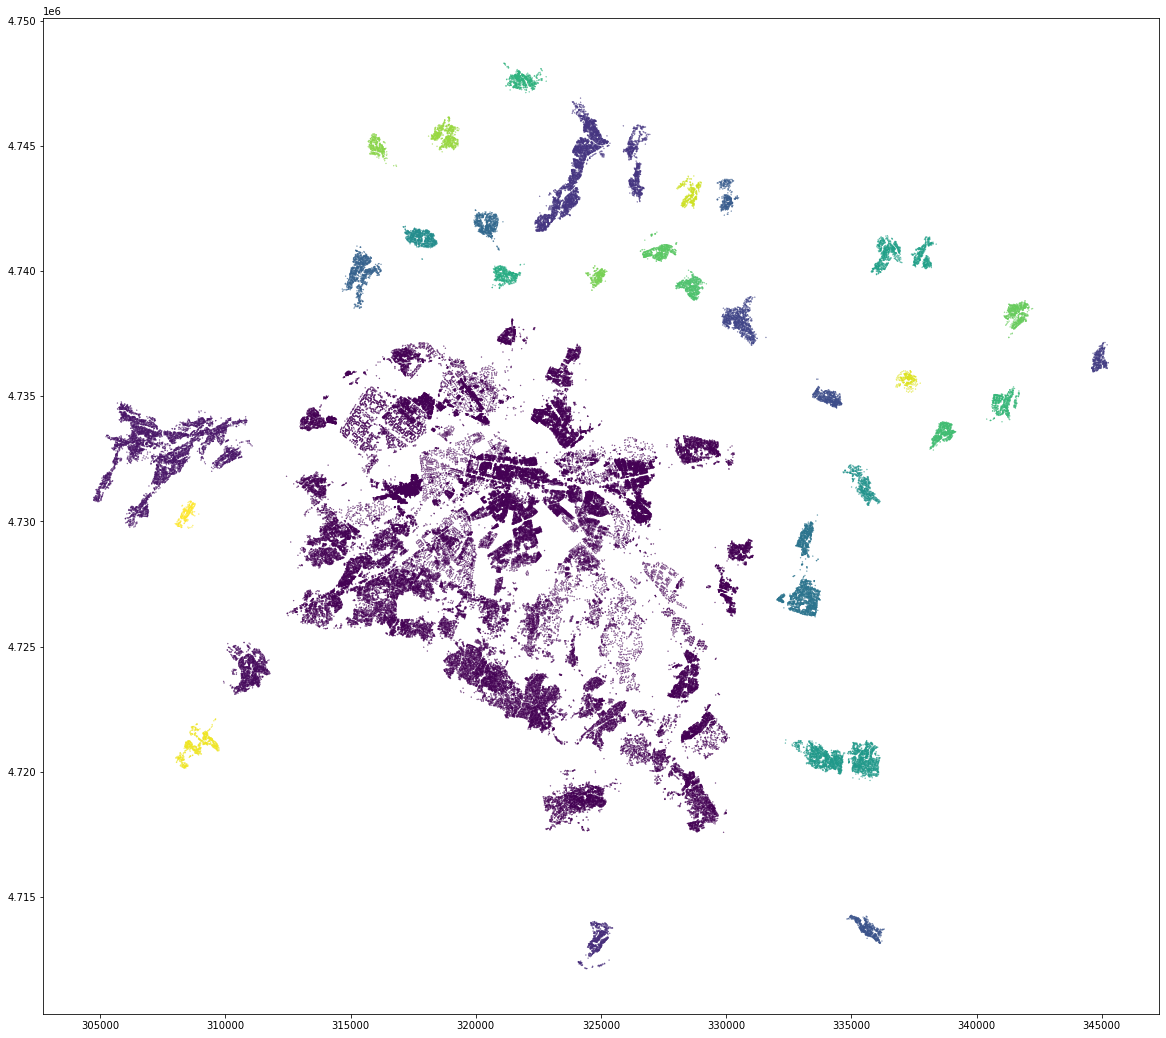

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
clusters_copy.plot(ax = ax , column = 'cl', markersize = 0.1)

## Optimization of the location of public services within each cluster
For each cluster given free parcels where new public services can potentially be constructed a linear algorithm is deployed (capacitated allocation model) in order to establish the ideal position of new services.

### Parameters that need to be set for the optimization
These parameters are key for the model to work they need to be set by an expert in urbanism.
- max_walkability - parameter that sets the maximum walking distance to a public service
- number_of_parcels - once all of the parcels are sorted this will not be included but for now this parameter refers to how many parcels you want the optimization to work on
- fixed_cost_of_public_services - this parameter is the most important one as it defines the fixed cost of facilities. It has to be set by an urbanist and standardized in order for the optimization to work
- maximum_capacity_of_the_of_the_roads - this translates into the maximum capacity of each kindergarten, for now it's left at 1/30

In [ ]:
max_walkability = 30
number_of_parcels = 20
fixed_cost_of_public_services = 1
maximum_capacity_of_the_of_the_roads = 1/30

### Linear optimization model

In [ ]:
clusters = gp.read_file(cluster_file)
cluster1 = clusters[clusters['cl'] == 1]
cluster1.reset_index(inplace=True, drop=True)
points = cluster1[['x', 'y']].to_numpy()
hull = ConvexHull(points)
p = Polygon([points[idx] for idx in hull.vertices])

streets = streets[streets.distance(p) == 0] 
properties = properties[properties.distance(p) == 0] 
test_properties = properties.iloc[random.sample(range(properties.shape[0]), number_of_parcels)]
test_properties.reset_index(inplace=True, drop=True)

nodes, graph = FromDF_ToNetwork_Db(streets, cluster1, test_properties, '50_perc_0_', '90_perc_3_', max_walkability)

I, demand = multidict({building : demand for (building, demand) in zip(cluster1.index, cluster1.children)})
J, capacity, initial_cost = multidict({kd : [area*maximum_capacity_of_the_building, area*fixed_cost_cost_of_public_services] for (kd, area) in zip(test_properties.index, test_properties.geometry.area)})
distances = ({(i,j): 0 if cluster1.iloc[i]['geometry'].distance(test_properties.iloc[j]['geometry']) <= 560 else 1000 for i in I for j in J})

model = CSCLP2(I, J, demand, capacity, initial_cost, distances)
model.optimize()

EPS = 0
x,y = model.data
edges = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > EPS]
facilities = [j for j in y if model.getVal(y[j]) > EPS]

C:\Users\STOYAN~1\AppData\Local\Temp/ipykernel_12256/790141993.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  streets = streets[streets.distance(p) == 0]
C:\Users\Stoyan Boyukliyski\anaconda3\envs\spamome\lib\site-packages\pygeos\measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\STOYAN~1\AppData\Local\Temp/ipykernel_12256/790141993.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  properties = properties[properties.distance(p) == 0]
C:\Users\Stoyan Boyukliyski\anaconda3\envs\spamome\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to r

Generating centroids...
Generating rtree...


100%|████████████████████████████████████████████████████████████████████████████| 1647/1647 [00:00<00:00, 1772.75it/s]
C:\Users\Stoyan Boyukliyski\anaconda3\envs\spamome\lib\site-packages\momepy\elements.py:719: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings_c[buildings_c.geometry.name] = buildings_c.centroid  # make centroids


Generating centroids...
Generating rtree...


Snapping: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2001.05it/s]
C:\Users\Stoyan Boyukliyski\anaconda3\envs\spamome\lib\site-packages\momepy\elements.py:819: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = objects.centroid
100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1330.22it/s]
C:\Users\STOYAN~1\AppData\Local\Temp/ipykernel_12256/790141993.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  J, capacity, initial_cost = multidict({kd : [area/30, area] for (kd, area) in zip(test_properties.index, test_properties.geometry.area)})


### Results from the optimization

In [ ]:
print("Optimal value=", model.getObjVal())
print("Facilities at nodes:", facilities)

Optimal value= 12721.934665799512
Facilities at nodes: [1, 3, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19]


### Show the resulting kindergartens

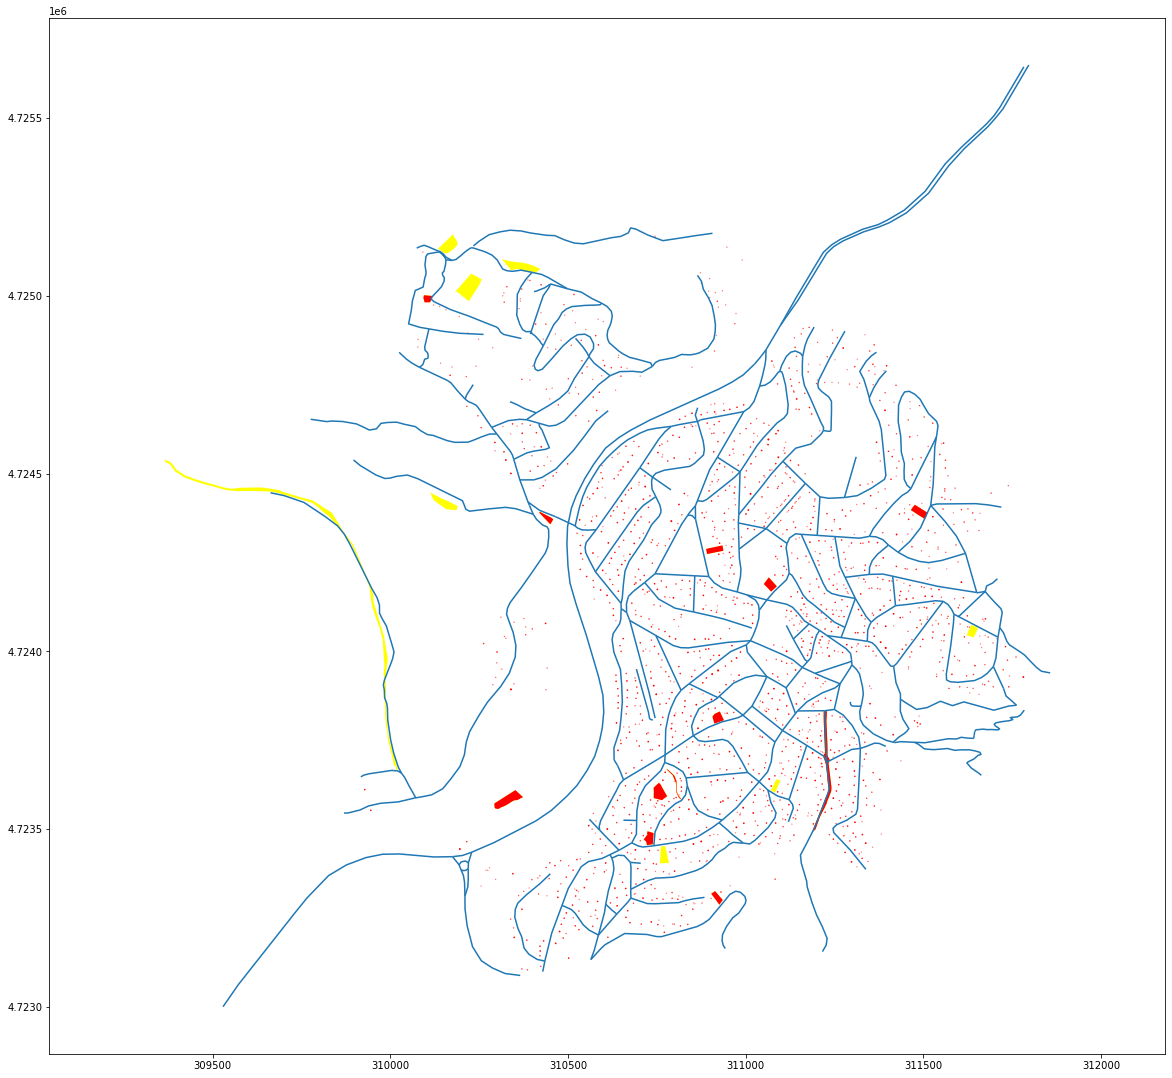

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_box_aspect(1.3)
nodes, edges = mp.nx_to_gdf(graph)
cluster1.plot(ax=ax, markersize=(cluster1['children']), color='red')
edges.plot(ax = ax)
test_properties.plot(ax=ax, color = 'yellow')
test_properties[test_properties.index.isin(facilities)].plot(ax=ax, color='red')
ax.set_aspect('equal', 'box')